In [3]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='api_key',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'predictivemaintenanceproject-donotdelete-pr-97d4qdtwvm868h'
object_key = 'predictive_maintenance.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_1 = pd.read_csv(body)
df_1.head(10)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,No Failure
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,No Failure
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,No Failure
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,No Failure
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,No Failure


In [4]:
# Check for missing values in each column
print(df_1.isnull().sum())

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64


In [5]:
# Separate features (X) and target (y)
X = df_1.drop(['Failure Type'], axis=1) # The features are all columns except 'Failure Type'
y = df_1['Failure Type'] # The target is the 'Failure Type' column

# Print the shapes to confirm
print("Shape of features (X):", X.shape)
print("Shape of target (y):", y.shape)

Shape of features (X): (10000, 9)
Shape of target (y): (10000,)


In [6]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable 'y'
y_encoded = label_encoder.fit_transform(y)

# Print the first 10 encoded values
print("First 10 encoded values:", y_encoded[:10])

# Print the original classes and their encoded values
print("Original Classes:", label_encoder.classes_)

First 10 encoded values: [1 1 1 1 1 1 1 1 1 1]
Original Classes: ['Heat Dissipation Failure' 'No Failure' 'Overstrain Failure'
 'Power Failure' 'Random Failures' 'Tool Wear Failure']


In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Print the shapes to confirm the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8000, 9)
X_test shape: (2000, 9)
y_train shape: (8000,)
y_test shape: (2000,)


In [9]:
# Drop the non-numerical columns from your features (X)
X_cleaned = X.drop(columns=['Product ID', 'Type'])

# Print the new shape to confirm the columns are gone
print("Shape of cleaned features (X_cleaned):", X_cleaned.shape)

# You also need to re-split the data with the new cleaned features
X_train_cleaned, X_test_cleaned, y_train, y_test = train_test_split(X_cleaned, y_encoded, test_size=0.2, random_state=42)

# Print the new shapes to confirm
print("X_train_cleaned shape:", X_train_cleaned.shape)
print("X_test_cleaned shape:", X_test_cleaned.shape)

Shape of cleaned features (X_cleaned): (10000, 7)
X_train_cleaned shape: (8000, 7)
X_test_cleaned shape: (2000, 7)


In [10]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the cleaned training data
model.fit(X_train_cleaned, y_train)

RandomForestClassifier(random_state=42)

In [11]:
# Make predictions on the test data
y_pred = model.predict(X_test_cleaned)

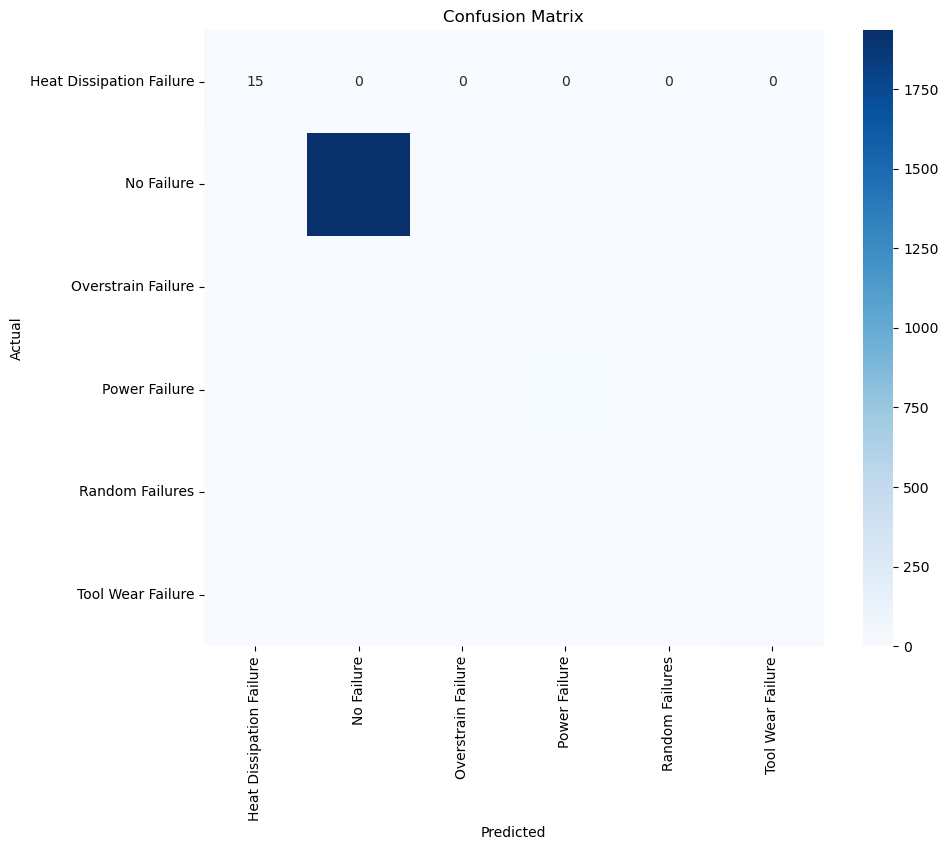

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print the report
print(report)

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.94      1.00      0.97        15
              No Failure       1.00      1.00      1.00      1935
      Overstrain Failure       0.79      0.85      0.81        13
           Power Failure       0.95      0.95      0.95        20
         Random Failures       0.00      0.00      0.00         6
       Tool Wear Failure       1.00      0.82      0.90        11

                accuracy                           0.99      2000
               macro avg       0.78      0.77      0.77      2000
            weighted avg       0.99      0.99      0.99      2000



/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
